In [1]:
# config
import torch
import torch.nn as nn

# hyperparameters
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cpu') if gpu_id < 0 else torch.device('cuda:%d' % gpu_id)
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 2

In [2]:
# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from utils import pid_diff_collate_fn
from torch.utils.data import DataLoader, random_split

dataset = ASSIST2009_PID_DIFF(max_seq_len)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

train_size = int( len(dataset) * train_ratio * (1 - valid_ratio))
valid_size = int( len(dataset) * train_ratio * valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [ train_size, valid_size, test_size ]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

In [3]:
from models.visualizer_monacobert import MonaConvBert4ktPlusDiff
from models.visualizer_monabert import MonaBert4ktPlusDiff
from models.visualizer_convbert import ConvBert4ktPlusDiff
from models.visualizer_bert import Bert4ktPlusDiff

model_monaco = MonaConvBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_mona = MonaBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)


model_co = ConvBert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_normal = Bert4ktPlusDiff(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_monaco_path = '/root/BiDKT/model_records/assist09.pth'
model_mona_path   = '/root/BiDKT/model_records/monabert4kt_plus_diff.pth'
model_co_path     = '/root/BiDKT/model_records/convbert4kt_plus_diff.pth'
model_normal_path = '/root/BiDKT/model_records/bert4kt_plus_diff.pth'

model_list = [model_monaco,model_mona,model_co,model_normal]
model_path_list = [model_monaco_path, model_mona_path, model_co_path, model_normal_path]

for model, model_path in zip(model_list, model_path_list):
    model_dict = torch.load(model_path)
    model.load_state_dict(model_dict['model'])

In [4]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Train MLM
# 15% <MASK>, 80% of 15% are real <MASK>, 10% of 15% are reverse, 10% of 15% are not changed
def Mlm4BertTrain(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    # <PAD> is -1
    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)
        # real_r_seq: r_seq with no <PAD>
        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        mlm_idx = np.random.choice(real_r_seq_len, int(real_r_seq_len*0.15), replace=False)

        for idx in mlm_idx:
            if random() < 0.8: # 15% of 80% are <MASK>
                real_r_seq[idx] = 2 # <MASK> is 2
            elif random() < 0.5: # 15% of 10% are random among the 0 or 1
                real_r_seq[idx] = randint(0, 1)
            # 15% of 10% are same with original

        # cover the PAD(-1)
        pad_len = r_len - real_r_seq_len
        # <PAD> is 3
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) 
        # combine the <PAD>
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        # append to the mlm_r_seqs
        mlm_r_seqs.append(pad_r_seq)

        # <MASK> idx bool
        # make zero vector with r_len size
        mlm_zeros = np.zeros(shape=(r_len, ))
        # mlm_idx are 1
        mlm_zeros[mlm_idx] = 1
        # append to the mlm_idxs
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    # mlm_r_seqs: masked r_seqs
    # mlm_idx: masked idx
    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class Tester():
    def __init__(
        self, 
        model, 
        optimizer, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
        
        # save the vis
        self.attn_dict = {head_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for head_idx in range(model.encoder[0].attn.num_attention_heads)}
        
    def _save_blackbox(self, data):
        '''save attn, filter, conv_value to self.~
        '''
        
        def _hook_blackbox(attn):
            '''get attn, filter, conv_value from self.model.encoder.attn
            attn_scores : [bs, head_idx, num_seq, num_seq]
            conv_values : [bs, num_seq, head_idx, hidden_dim]
            conv_filter : [bs, num_seq, head_idx, kernel_size]
            '''
            attn_scores = attn.attn_scores 
            return {'attn' : attn_scores}
        
        # organize data, hook to easily get the attr
        batch = [torch.stack([q_seqs.type(torch.long), 
                              r_seqs.type(torch.long), 
                              pid_seqs.type(torch.long), 
                              diff_seqs.type(torch.long), 
                              mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs in zip(*data)]

        attn_list = [self.model.encoder[encoder_idx].attn for encoder_idx in range(num_encoder)]
        hook_list = list(map(_hook_blackbox, attn_list))

        attn_layers = torch.stack([hook['attn'] for hook in hook_list], dim = 1) # [bs, layer_idx, head_idx, num_seq, num_seq]
        
        # save hook to self.~
        for seq_idx, seq in enumerate(batch):
            for sample_idx, sample in enumerate(seq):
                q    = int(sample[0])
                r    = int(sample[1])
                pid  = int(sample[2])
                diff = int(sample[3])
                is_mask = bool(sample[4])                
                
                if is_mask is True:
                    for encoder_idx in range(num_encoder):
                        # save attn
                        for head_idx in range(model.encoder[0].attn.num_attention_heads):
                            self.attn_dict[head_idx][encoder_idx] += [attn_layers[seq_idx, encoder_idx, head_idx, ...]]
                        
        
    def test(self, test_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )
                
                self._save_blackbox(data)

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                y_trues.append(correct)
                y_scores.append(y_hat)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

In [5]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

trainer_list = []
for model in model_list:    
    optimizer = Adam(model.parameters(), learning_rate)
    crit = binary_cross_entropy
    
    trainer = Tester(
        model=model,
        optimizer=optimizer,
        n_epochs=n_epochs,
        device=device,
        num_q=num_q,
        crit=crit,
        max_seq_len=max_seq_len,
        grad_acc=grad_acc,
        grad_acc_iter=grad_acc_iter
    )
    
    trainer_list.append(trainer)

In [6]:
%%time
from einops import rearrange

for trainer in trainer_list:
    auc_score = trainer.test(test_loader)

100%|██████████| 17/17 [00:34<00:00,  2.01s/it]

CPU times: user 31.5 s, sys: 2.75 s, total: 34.2 s
Wall time: 34.2 s


In [10]:
import matplotlib.pyplot as plt
def vis_attn(
    trainer,
    model_name :str = 'None',
    layer_avg = False,
    head_avg  = False,
    save_plot = False,
):
    num_encoder = 1 if layer_avg else 12
    num_head = 1 if head_avg else 8
    
    fig, axs = plt.subplots(num_encoder, num_head)
    for encoder_idx in range(num_encoder):
        for head_idx in range(num_head):
            
            attn_map = torch.zeros(100, 100, device = 'cuda:0')
            if layer_avg:
                for enc in range(8):
                    attn_map += torch.mean(torch.stack(trainer.attn_dict[head_idx][enc], dim = 0), dim = 0)
            elif head_avg:
                for head in range(12):
                    attn_map += torch.mean(torch.stack(trainer.attn_dict[head][encoder_idx], dim = 0), dim = 0)
            else:
                attn_map += torch.mean(torch.stack(trainer.attn_dict[head_idx][encoder_idx], dim = 0), dim = 0)
                
            if layer_avg:
                axs[head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            elif head_avg:
                axs[encoder_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            else:
                axs[encoder_idx, head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            
    fig.suptitle(f'attn_map')
    if save_plot:
        plt.savefig(f'../model_records/attn_map-{model_name}-layer_avg-{layer_avg}-head_avg-{head_avg}.png')
    else:
        plt.show()

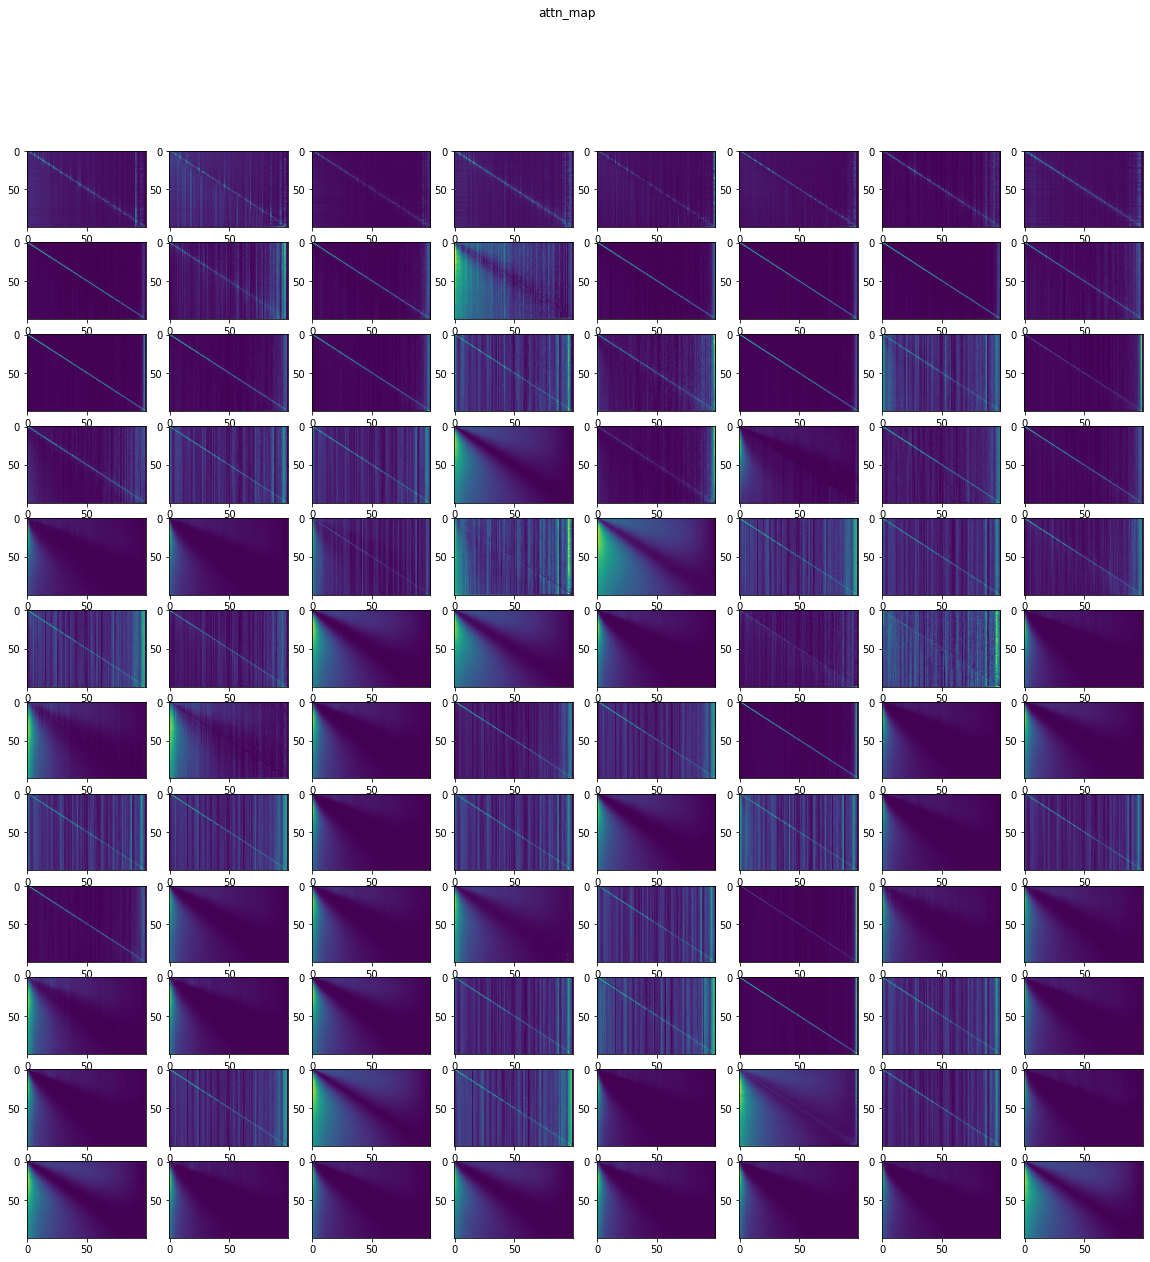

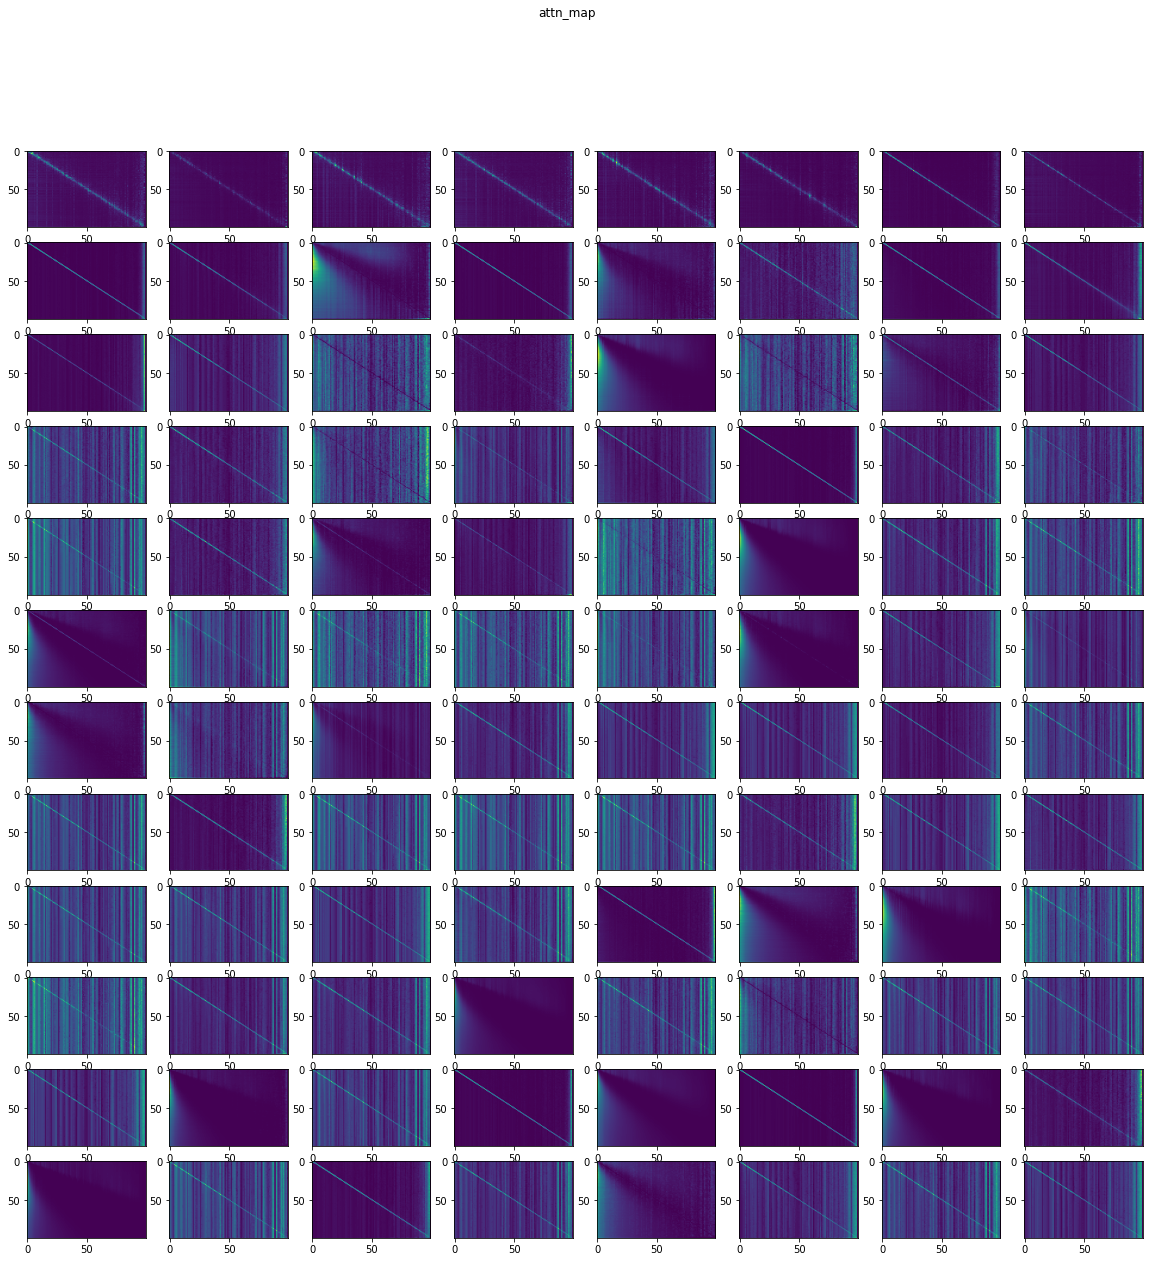

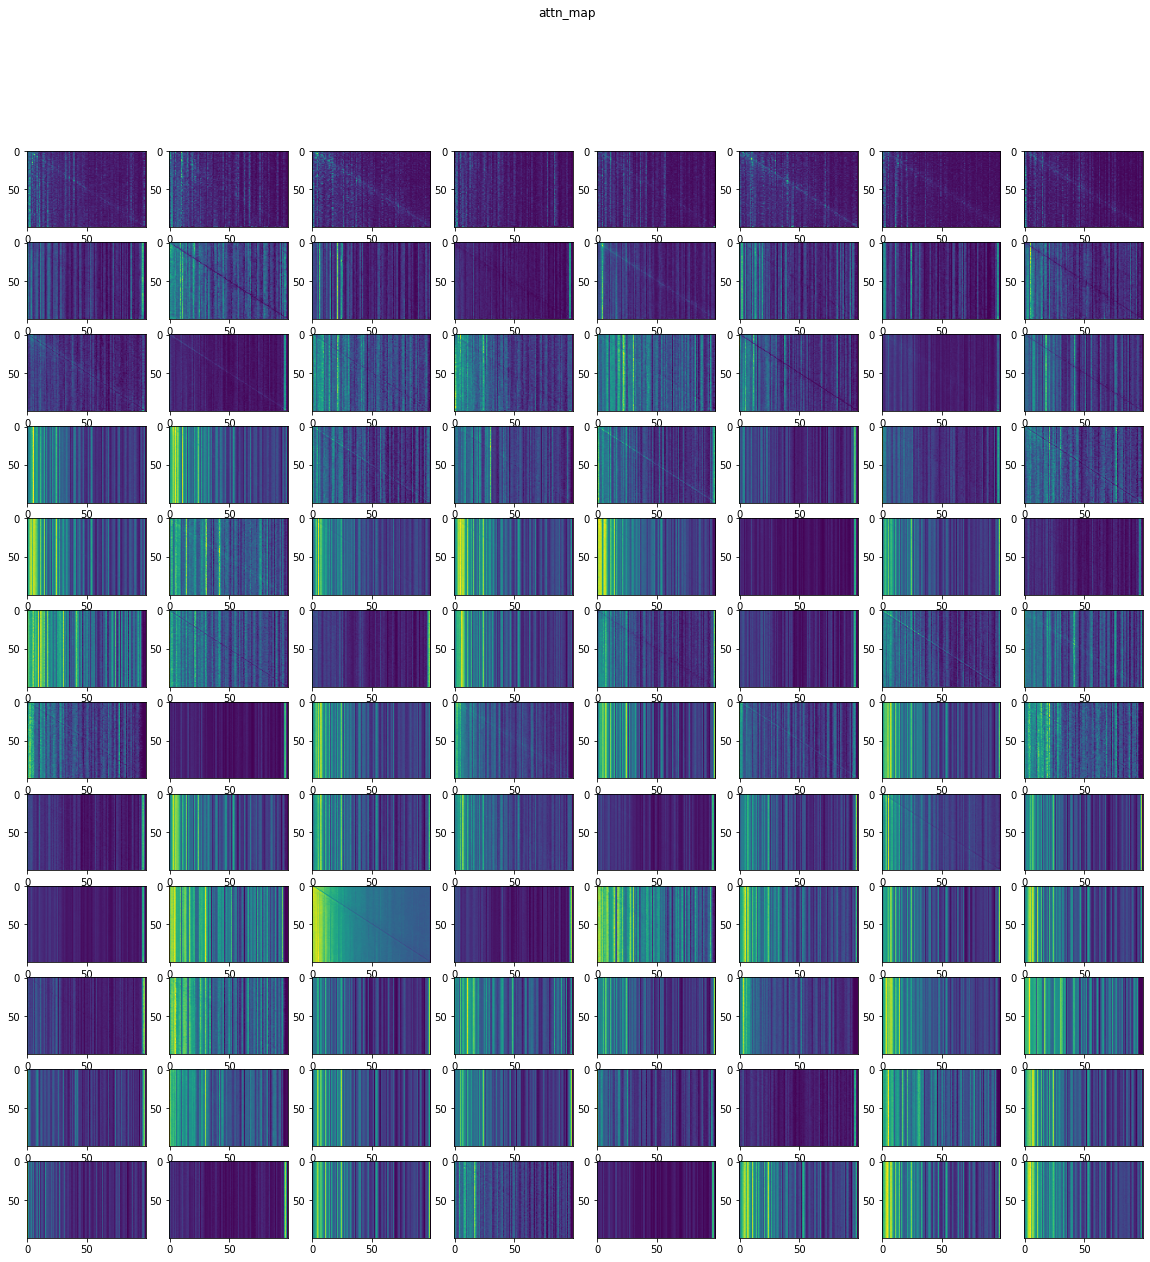

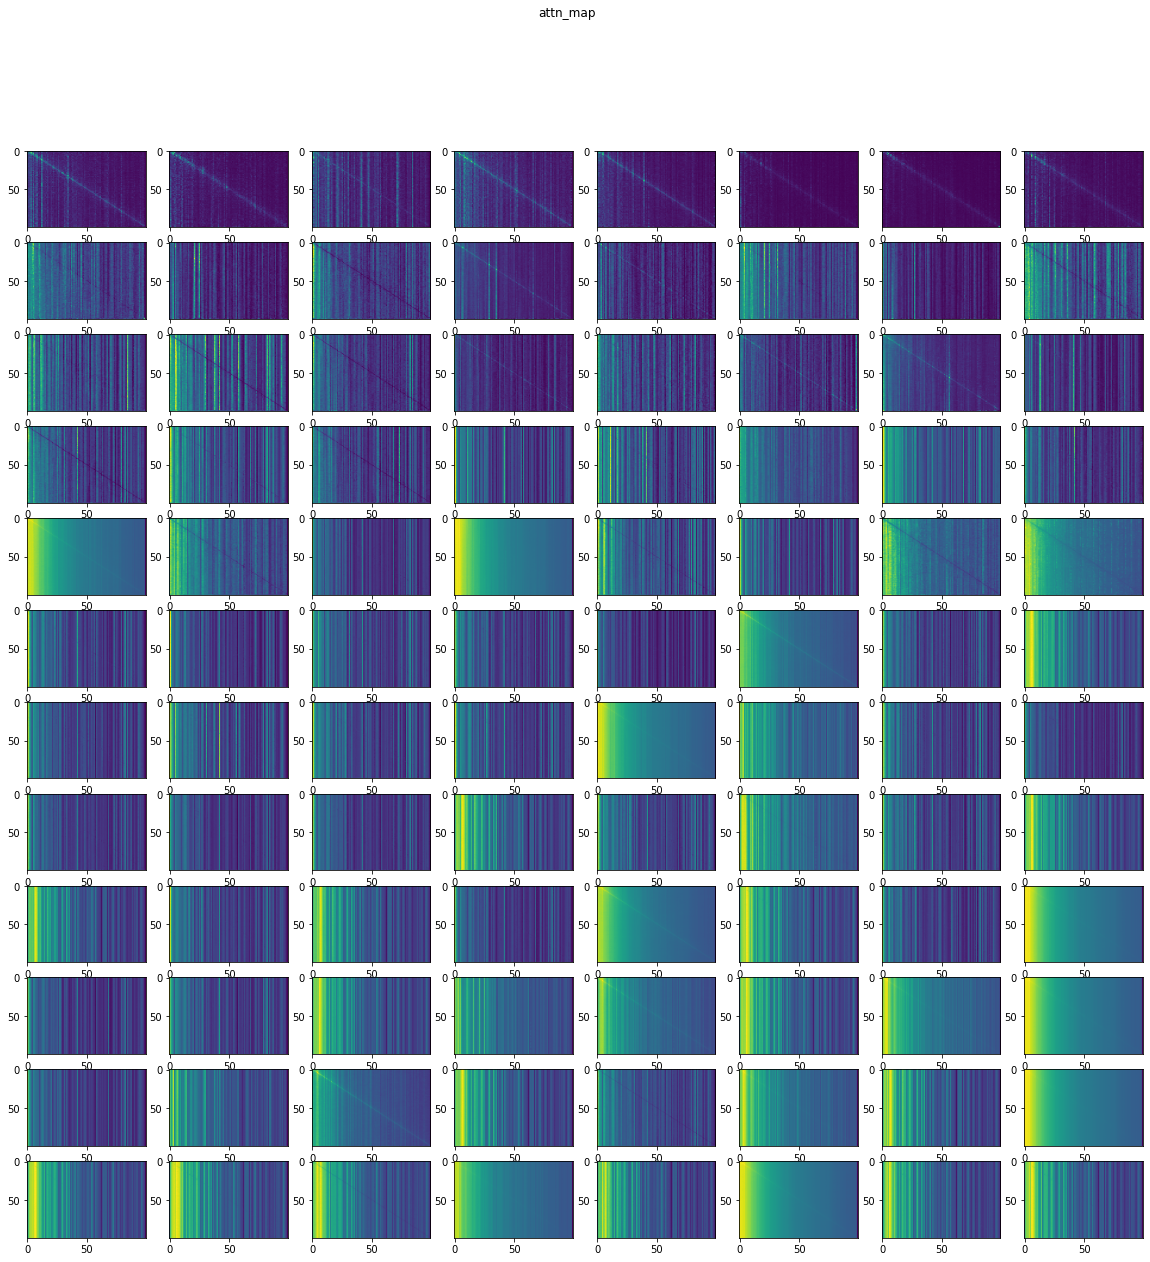

In [11]:
plt.rcParams["figure.figsize"] = (20,20)

model_name_list = ['MonaConvBert4ktPlusDiff', 'MonaBert4ktPlusDiff', 'ConvBert4ktPlusDiff', 'Bert4ktPlusDiff']
for trainer, model_name in zip(trainer_list, model_name_list):
    vis_attn(
        trainer    = trainer,
        model_name = model_name,
        layer_avg = False,
        head_avg  = False,
        save_plot = False,
    )